In [47]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, Nadam, SGD, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks imposrt EarlyStopping
import keras_tuner

tf.keras.backend.clear_session()
seed = 9
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)

## Preprocess Data

In [2]:
def get_file_paths_and_labels(directory, class_names):
    
    file_paths = []
    labels = []

    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            # Gather file paths for images in this class
            image_files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)]
            file_paths.extend(image_files)

            # Assign labels to these images
            labels.extend([class_name] * len(image_files))
            
    data = {'X_path': file_paths, 'y': labels}
    df = pd.DataFrame(data)
    
    return df

# Define the root directory for your dataset
train_directory = './train'
test_directory = './test'


# List subdirectories (classes)
train_classes = os.listdir(train_directory)
test_classes = os.listdir(test_directory)


train_data = get_file_paths_and_labels(train_directory, train_classes)
test_data = get_file_paths_and_labels(test_directory, test_classes)



In [3]:
train_data.head()

,X_path,y
0,./train\FAKE\1000 (10).jpg,FAKE
1,./train\FAKE\1000 (2).jpg,FAKE
2,./train\FAKE\1000 (3).jpg,FAKE
3,./train\FAKE\1000 (4).jpg,FAKE
4,./train\FAKE\1000 (5).jpg,FAKE


In [4]:
#Replace the strings 'FAKE' and 'REAL' with Boolean variables. In this case 'False' means fake and 'True' means real.
train_data['y'] = train_data['y'].replace({'FAKE': False, 'REAL': True})
test_data['y'] = test_data['y'].replace({'FAKE': False, 'REAL': True})

In [5]:
print(train_data.head())
print(test_data.head())

                       X_path      y
0  ./train\FAKE\1000 (10).jpg  False
1   ./train\FAKE\1000 (2).jpg  False
2   ./train\FAKE\1000 (3).jpg  False
3   ./train\FAKE\1000 (4).jpg  False
4   ./train\FAKE\1000 (5).jpg  False
                   X_path      y
0  ./test\FAKE\0 (10).jpg  False
1   ./test\FAKE\0 (2).jpg  False
2   ./test\FAKE\0 (3).jpg  False
3   ./test\FAKE\0 (4).jpg  False
4   ./test\FAKE\0 (5).jpg  False


In [6]:
#Shuffle the training dataframe
train_data = train_data.sample(frac=1).reset_index(drop=True)

In [7]:
train_data.head()

,X_path,y
0,./train\FAKE\1934 (8).jpg,False
1,./train\REAL\3727 (8).jpg,True
2,./train\REAL\3559 (2).jpg,True
3,./train\REAL\4675 (5).jpg,True
4,./train\REAL\1320 (4).jpg,True


In [8]:
def extract_images(image_path_col):
    
    """
    Function to read and normalise the images from the path specified in a given dataframe.
    Inputs: The column from the dataframe you wish to extract images from
    Outputs: An array of normalised images from chosen dataframe
    """
    
    images_list = []
    
    for i in image_path_col:
        image = cv2.imread(i)
        images_list.append(image)
    image_array = np.array(images_list)
    
    #normalise the images
    X_vals = image_array/255
    
    return X_vals

In [9]:
X_train  = extract_images(train_data['X_path'])
X_test  = extract_images(test_data['X_path'])

In [10]:
y_train = train_data['y']
y_test = test_data['y']

## Build Model Through Keras Tuner

In [24]:
def model_builder(hp):
    # create a Sequential model
    model = Sequential()
    
    # convolutional layers with hyperparameter tuning
    filters_param1 = hp.Int('filters1', min_value=20, max_value=100, step=20)
    kernel_size_param1 = hp.Int('kernel_size1', min_value=2, max_value=4, step=1)
    model.add(Conv2D(filters=filters_param1, kernel_size=(kernel_size_param1, kernel_size_param1), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPool2D((2, 2)))
    
    
    # flatten layer
    model.add(Flatten())
    
    # define hyperparameter values to search for   
    activation_param = hp.Choice('activation', values=['relu', 'tanh'])
    dense_layer1_param = hp.Int('layer1', min_value=100, max_value=1000, step=100)
    dense_layer2_param = hp.Int('layer2', min_value=100, max_value=1000, step=100)
    
    # add dense layers to the model with values from the hyperparameter space
    model.add(Dense(units=dense_layer1_param, activation=activation_param))
    model.add(Dense(units=dense_layer2_param, activation=activation_param))
    model.add(Dense(2, activation='sigmoid'))
    
    
    # hyperparameter choices for optimizer 
    lr_param = hp.Choice('learning_rate', values= [0.001, 0.0005, 0.0001])
    optimizer_param = hp.Choice('optimizer', values=['adam', 'sgd'])
    
    
    
    
    # define optimizers based on the hyperparameter choice, options are: adam and SGD
    if optimizer_param == 'adam':
        optimizer = Adam(learning_rate=lr_param)
    else:
        optimizer = SGD(learning_rate=lr_param)
    
    # Compile the model with the selected optimizer
    model.compile(optimizer=optimizer, 
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    return model

In [29]:
# Create a Hyperband tuner for hyperparameter optimization
tuner = keras_tuner.Hyperband(
    model_builder,             # call our function to build the model
    objective='val_accuracy',  # define metric to optimize
    max_epochs=15,             # Max number of training epochs per model
    factor=3,                  
    directory='G:/0_KAGGLE/hband_weights',           
    project_name='hband_tuner'           
)


In [30]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # define early stop

In [31]:
# use Hyperband tuner to search for the best hyperparameters
tuner.search(
    X_train,                    # Training data
    y_train,                    # Training labels
    epochs=10,                  # number of training epochs per model
    validation_split=0.2,       # Fraction of training data used for validation
    callbacks=[early_stop]      # define callback as our early stop method
)


Trial 30 Complete [00h 11m 19s]
val_accuracy: 0.9249500036239624

Best val_accuracy So Far: 0.9368500113487244
Total elapsed time: 07h 22m 45s


In [34]:
best_params = tuner.get_best_hyperparameters(num_trials=1)[0] #get the best performing hyperparameters

# List of hyperparameters to iterate through
hyperparameter_names = ['filters1', 'kernel_size1', 'activation', 'layer1', 'layer2', 'learning_rate', 'optimizer']

# Iterate through the list and display the best values
print("Best Hyperparameters:")
for param_name in hyperparameter_names:
    param_value = best_params.get(param_name)
    print(f"{param_name.capitalize()}: {param_value}")

Best Hyperparameters:
Filters1: 80
Kernel_size1: 3
Activation: relu
Layer1: 200
Layer2: 1000
Learning_rate: 0.0001
Optimizer: adam


In [35]:
#build model with best params
best_model = tuner.hypermodel.build(best_params) 

early_stop_best_model = EarlyStopping(monitor='val_loss', patience=7)  # define early stop for training the best model


#train best model on the train data
history = best_model.fit(X_train, y_train, epochs=50, validation_split=0.15, callbacks=[early_stop_best_model]) 

Epoch 1/50
2657/2657 [==============================] - 165s 62ms/step - loss: 0.3331 - accuracy: 0.8524 - val_loss: 0.2451 - val_accuracy: 0.9002
Epoch 2/50
2657/2657 [==============================] - 161s 61ms/step - loss: 0.2165 - accuracy: 0.9134 - val_loss: 0.2040 - val_accuracy: 0.9169
Epoch 3/50
2657/2657 [==============================] - 162s 61ms/step - loss: 0.1742 - accuracy: 0.9308 - val_loss: 0.1865 - val_accuracy: 0.9259
Epoch 4/50
2657/2657 [==============================] - 163s 61ms/step - loss: 0.1427 - accuracy: 0.9450 - val_loss: 0.1715 - val_accuracy: 0.9321
Epoch 5/50
2657/2657 [==============================] - 161s 61ms/step - loss: 0.1170 - accuracy: 0.9549 - val_loss: 0.1902 - val_accuracy: 0.9293
Epoch 6/50
2657/2657 [==============================] - 159s 60ms/step - loss: 0.0928 - accuracy: 0.9648 - val_loss: 0.1729 - val_accuracy: 0.9353
Epoch 7/50
2657/2657 [==============================] - 160s 60ms/step - loss: 0.0721 - accuracy: 0.9730 - val_loss: 0

In [40]:
#evaluate best model on the test data
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

625/625 [==============================] - 6s 9ms/step - loss: 0.2734 - accuracy: 0.9297
Test Accuracy: 92.97%
Test Loss: 0.2734


In [37]:
history_df = pd.DataFrame(history.history)

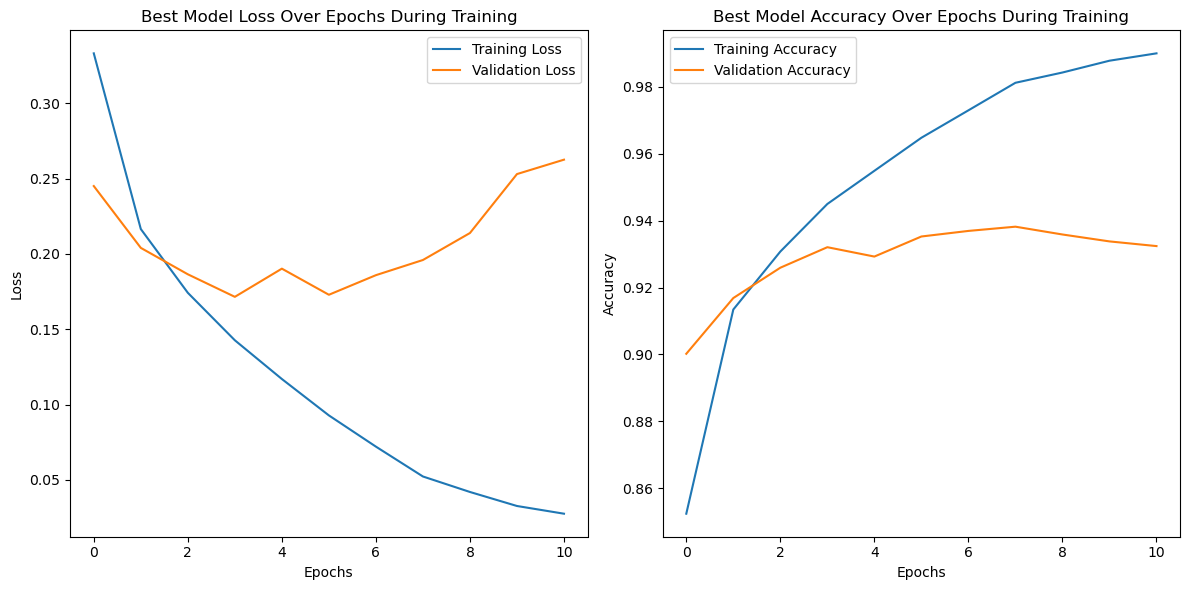

In [38]:
# Plot the loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Best Model Loss Over Epochs During Training')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Best Model Accuracy Over Epochs During Training')

plt.tight_layout()
plt.show()


In [50]:
# Evaluate best model on the test data
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

625/625 [==============================] - 5s 8ms/step


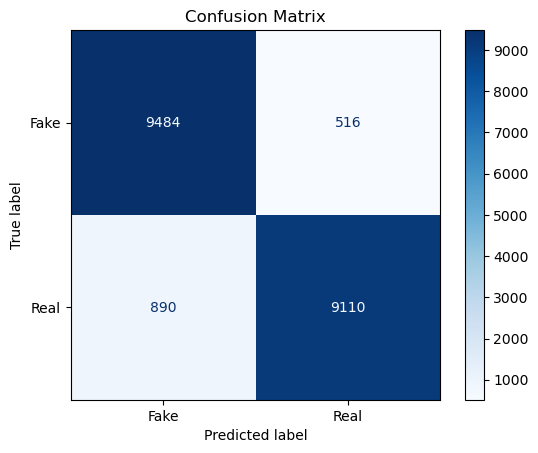

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



# Convert True/False labels back to 0/1 for the confusion matrix
y_test_numeric = y_test.astype(int)

# Create the confusion matrix
cm = confusion_matrix(y_test_numeric, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()